In [1]:
import os, sys, time
import numpy as np
np.random.seed(1234)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import tensorflow as tf
import keras
from keras import backend as K
print('keras backend: ', K._BACKEND)
print('keras version: ', keras.__version__)
print('tensorflow version: ', tf.__version__)

sess = tf.Session()
K.set_session(sess)
# fix input size in model for tensorflow
K.set_image_dim_ordering('tf')
# K.set_image_dim_ordering('th')

Using TensorFlow backend.


keras backend:  tensorflow
keras version:  2.0.8
tensorflow version:  1.3.0


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge
from keras.layers import Conv2D, MaxPooling2D, Cropping2D, concatenate, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

In [3]:
def loadDataList(path):
    data = []
    dataM = []
    for file in os.listdir(path):
        if file.endswith('.tiff'):
            if 'm' in file:
                dataM.append(path + '\\' + file)
            else:
                data.append(path + '\\' + file)
    return data, dataM

In [4]:
def loadTiff(path):
    #import Tifffile
    #return Tifffile.imread(path)
    return plt.imread(path)
    #import PIL
    #return PIL.Image.open(path)
    
def loadImagesInList(ims):
    images = np.zeros((len(ims), _SIZEX, _SIZEY, 3), dtype=np.uint8)
    for i in range(len(ims)):
        images[i] = loadTiff(ims[i])
    return images

def loadImagesInListLabels(ims):
    images = np.zeros((len(ims), _SIZEX, _SIZEY), dtype=np.uint8)
    for i in range(len(ims)):
        images[i] = loadTiff(ims[i])
    return images

def splitImages(images, splitX):
    nums = images.shape[0]
    sizeX = images.shape[1]
    sizeY = images.shape[2]
    channels = images.shape[3]
    X = int(sizeX / splitX)
    Y = int(sizeY / splitX)
    ims = np.zeros((nums*splitX*splitX, X, Y, channels), dtype=np.uint8)
    #print(images.shape)
    #print(ims.shape)
    X = int(sizeX / splitX)
    Y = int(sizeY / splitX)
    for i in range(nums):
        counter = 0
        for j in range(splitX):
            x = X*j
            for k in range(splitX):
                y = Y*k
                #print(i, x, y)
                ims[i*splitX*splitX + counter, :, :, :] = images[i, x:x+X, y:y+Y, :]
                counter += 1
    return ims
def splitImagesLabels(images, splitX):
    nums = images.shape[0]
    sizeX = images.shape[1]
    sizeY = images.shape[2]
    X = int(sizeX / splitX)
    Y = int(sizeY / splitX)
    ims = np.zeros((nums*splitX*splitX, X, Y, 1), dtype=np.uint8)
    X = int(sizeX / splitX)
    Y = int(sizeY / splitX)
    for i in range(nums):
        counter = 0
        for j in range(splitX):
            x = X*j
            for k in range(splitX):
                y = Y*k
                ims[i*splitX*splitX + counter, :, :, 0] = images[i, x:x+X, y:y+Y]
                counter += 1
    return ims

In [5]:
smooth = 1e-12
def jaccard_coef(y_true, y_pred):
    ax = [0, -1, -2]
    #ax = [-1, -2, 0]
    intersection = K.sum(y_true * y_pred, axis=ax)
    sum_ = K.sum(y_true + y_pred, axis=ax)

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    ax = [0, -1, -2]
    #ax = [-1, -2, 0]
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=ax)
    sum_ = K.sum(y_true + y_pred, axis=ax)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [6]:
class UNet():
    def __init__(self):
        print('building UNet')
    
    def getCropShape(self, target, refer):
        #width, the 3rd dimension
        cw = (target.get_shape()[2] - refer.get_shape()[2]).value
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        #height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1]).value
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)
        return (ch1, ch2), (cw1, cw2)
    
    def createModel(self, imgShape, numClasses):
        concatAxis = 3
        inputs = keras.layers.Input(shape = imgShape)
        
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
        pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
        
        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
        pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
        
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
        pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
        
        conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
        conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
        pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
        
        conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
        conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
        
        up_conv5 = UpSampling2D(size=(2,2))(conv5)
        ch, cw = self.getCropShape(conv4, up_conv5)
        crop_conv4 = Cropping2D(cropping=(ch, cw))(conv4)
        up6 = concatenate([up_conv5, crop_conv4], axis=concatAxis)
        conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
        conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
        
        up_conv6 = UpSampling2D(size=(2,2))(conv6)
        ch, cw = self.getCropShape(conv3, up_conv6)
        crop_conv3 = Cropping2D(cropping=(ch, cw))(conv3)
        up7 = concatenate([up_conv6, crop_conv3], axis=concatAxis)
        conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
        conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
        
        up_conv7 = UpSampling2D(size=(2,2))(conv7)
        ch, cw = self.getCropShape(conv2, up_conv7)
        crop_conv2 = Cropping2D(cropping=(ch, cw))(conv2)
        up8 = concatenate([up_conv7, crop_conv2], axis=concatAxis)
        conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
        conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
        
        up_conv8 = UpSampling2D(size=(2,2))(conv8)
        ch, cw = self.getCropShape(conv1, up_conv8)
        crop_conv1 = Cropping2D(cropping=(ch, cw))(conv1)
        up9 = concatenate([up_conv8, crop_conv1], axis=concatAxis)
        conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
        conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
        
        ch, cw = self.getCropShape(inputs, conv9)
        conv9 = ZeroPadding2D(padding=(ch, cw))(conv9)
        conv10 = Conv2D(numClasses, (1, 1))(conv9)
        
        model = keras.models.Model(inputs=inputs, outputs=conv10)
        model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
        return model

def createUNet(imgShape, numClasses):
    concatAxis = 3
    inputs = keras.layers.Input(shape = imgShape)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    print('conv1 shape', conv1.shape)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    print('pool1 shape', pool1.shape)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    print('conv2 shape', conv2.shape)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    print('pool2 shape', pool2.shape)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    print('conv3 shape', conv3.shape)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    print('pool3 shape', pool3.shape)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    print('conv4 shape', conv4.shape)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    print('pool4 shape', pool4.shape)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    print('conv5 shape', conv5.shape)

    #up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=concatAxis)
    print('up6 = Up(conv5) + conv4', conv5.shape, '+', conv4.shape)
    up6 = concatenate([UpSampling2D(size=(2,2))(conv5), conv4], axis=concatAxis)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    print('conv6 shape', conv6.shape)

    #up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=concatAxis)
    print('up7 = Up(conv6) + conv3', conv6.shape, '+', conv3.shape)
    up7 = concatenate([UpSampling2D(size=(2,2))(conv6), conv3], axis=concatAxis)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    print('conv7 shape', conv7.shape)

    #up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=concatAxis)
    print('up8 = Up(conv7) + conv2', conv7.shape, '+', conv2.shape)
    up8 = concatenate([UpSampling2D(size=(2,2))(conv7), conv2], axis=concatAxis)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    print('conv8 shape', conv8.shape)

    #up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=concatAxis)
    print('up9 = Up(conv8) + conv1', conv8.shape, '+', conv1.shape)
    up9 = concatenate([UpSampling2D(size=(2,2))(conv8), conv1], axis=concatAxis)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    print('conv9 shape', conv9.shape)

    conv10 = Conv2D(numClasses, (1, 1), activation='sigmoid')(conv9)
    print('conv10 shape', conv10.shape)

    model = keras.models.Model(input=inputs, output=conv10)
    model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    print(model.summary())
    return model

In [7]:
dataPath = 'M:\MLData\MassachusettsArial\Roads'
trainPath = dataPath + '\\train'
testPath = dataPath + '\\test'
validdationPath = dataPath + '\\validation'
train, trainM = loadDataList(trainPath)
test, testM = loadDataList(testPath)
validation, validationM = loadDataList(validdationPath)
print('train length: %i' %(len(train)))
print('test length: %i' %(len(test)))
print('validation length: %i' %(len(validation)))

_SIZEX = 1500
_SIZEY = 1500

train length: 1108
test length: 49
validation length: 14


In [8]:
trainX = loadImagesInList(train[0:50])
trainY = loadImagesInListLabels(trainM[0:50])
validationX = loadImagesInList(validation[0:5])
validationY = loadImagesInListLabels(validationM[0:5])
testX = loadImagesInList(test[0:5])
testY = loadImagesInListLabels(testM[0:5])

In [9]:
trainXnew = splitImages(trainX, 5)
trainYnew = splitImagesLabels(trainY, 5)
validationXnew = splitImages(validationX, 5)
validationYnew = splitImagesLabels(validationY, 5)
testXnew = splitImages(testX, 5)
testYnew = splitImagesLabels(testY, 5)

print('trainX shape', trainXnew.shape)
print('trainY shape', trainYnew.shape)
print('validationX shape', validationXnew.shape)
print('validationY shape', validationYnew.shape)

trainX shape (1250, 300, 300, 3)
trainY shape (1250, 300, 300, 1)
validationX shape (125, 300, 300, 3)
validationY shape (125, 300, 300, 1)


In [19]:
trainX = np.zeros((trainXnew.shape[0], 288, 288, 3), dtype=np.uint8)
trainY = np.zeros((trainXnew.shape[0], 288, 288, 1), dtype=np.uint8)
validationX = np.zeros((validationXnew.shape[0], 288, 288, 3), dtype=np.uint8)
validationY = np.zeros((validationXnew.shape[0], 288, 288, 1), dtype=np.uint8)
testX = np.zeros((testXnew.shape[0], 288, 288, 3), dtype=np.uint8)
testY = np.zeros((testXnew.shape[0], 288, 288, 1), dtype=np.uint8)
trainX = trainXnew[:, 0:288, 0:288, :] / 255
trainY = trainYnew[:, 0:288, 0:288, :] / 255
#trainY = trainY > 0
trainY[trainY > 0] = 1
validationX = validationXnew[:, 0:288, 0:288, :] / 255
validationY = validationYnew[:, 0:288, 0:288, :] / 255
testX = testXnew[:, 0:288, 0:288, :] / 255
testY = testYnew[:, 0:288, 0:288, :] / 255

print('trainX shape', trainX.shape)
print('trainY shape', trainY.shape)
print('validationX shape', validationX.shape)
print('validationY shape', validationY.shape)

trainX shape (1250, 288, 288, 3)
trainY shape (1250, 288, 288, 1)
validationX shape (125, 288, 288, 3)
validationY shape (125, 288, 288, 1)


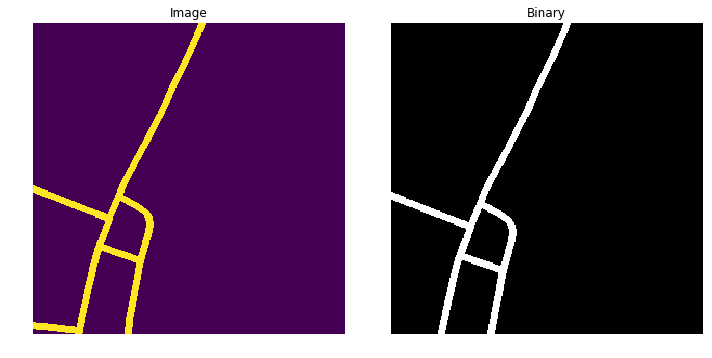

255
1.0


In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
ax = axes.ravel()
ax[0].imshow(trainYnew[2,:,:,0])
ax[0].set_title('Image')
ax[0].axis('off')
ax[1].imshow(trainY[2,:,:,0], cmap='binary_r')
ax[1].set_title('Binary')
ax[1].axis('off')
plt.tight_layout()
plt.show()
print(trainYnew[2].max())
print(trainY[2].max())

In [12]:
model = createUNet((288, 288, 3), 1)

conv1 shape (?, 288, 288, 32)
pool1 shape (?, 144, 144, 32)
conv2 shape (?, 144, 144, 64)
pool2 shape (?, 72, 72, 64)
conv3 shape (?, 72, 72, 128)
pool3 shape (?, 36, 36, 128)
conv4 shape (?, 36, 36, 256)
pool4 shape (?, 18, 18, 256)
conv5 shape (?, 18, 18, 512)
up6 = Up(conv5) + conv4 (?, 18, 18, 512) + (?, 36, 36, 256)
conv6 shape (?, 36, 36, 256)
up7 = Up(conv6) + conv3 (?, 36, 36, 256) + (?, 72, 72, 128)
conv7 shape (?, 72, 72, 128)
up8 = Up(conv7) + conv2 (?, 72, 72, 128) + (?, 144, 144, 64)
conv8 shape (?, 144, 144, 64)
up9 = Up(conv8) + conv1 (?, 144, 144, 64) + (?, 288, 288, 32)
conv9 shape (?, 288, 288, 32)
conv10 shape (?, 288, 288, 1)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 288, 288, 3)   0                                            
___________________________________________

C:\Users\Christopher\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:144: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [13]:
datagen = ImageDataGenerator(
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False)

val_datagen = ImageDataGenerator()

gen = datagen.flow(trainX, trainY, batch_size=32)
val_gen = val_datagen.flow(validationX, validationY, batch_size=64)

history = model.fit_generator(gen, steps_per_epoch=trainX.shape[0] / 32, epochs=20,)

#history = model.fit_generator(datagen.flow(trainX, trainY, batch_size=32),
#                    steps_per_epoch=trainX.shape[0] / 32, epochs=2,
#                             validation_data=val_datagen)

#history = model.fit(trainX, trainY, batch_size=64, epochs=10, verbose=1, shuffle=True,
#          validation_data=(validationX, validationY))

Epoch 1/20
40/39 [==============================] - 38s - loss: 0.2362 - jaccard_coef: 0.0205 - jaccard_coef_int: 2.1986e-07 - acc: 0.9613    
Epoch 2/20
40/39 [==============================] - 33s - loss: 0.1284 - jaccard_coef: 0.0642 - jaccard_coef_int: 3.0485e-15 - acc: 0.9624    
Epoch 3/20
40/39 [==============================] - 33s - loss: 0.1214 - jaccard_coef: 0.0890 - jaccard_coef_int: 2.3611e-15 - acc: 0.9619    
Epoch 4/20
40/39 [==============================] - 34s - loss: 0.1133 - jaccard_coef: 0.1217 - jaccard_coef_int: 0.0158 - acc: 0.9625    
Epoch 5/20
40/39 [==============================] - 33s - loss: 0.1073 - jaccard_coef: 0.1767 - jaccard_coef_int: 0.1720 - acc: 0.9667    
Epoch 6/20
40/39 [==============================] - 33s - loss: 0.1032 - jaccard_coef: 0.1976 - jaccard_coef_int: 0.1896 - acc: 0.9680    
Epoch 7/20
40/39 [==============================] - 33s - loss: 0.1117 - jaccard_coef: 0.1423 - jaccard_coef_int: 0.1052 - acc: 0.9652    
Epoch 8/20
40/3

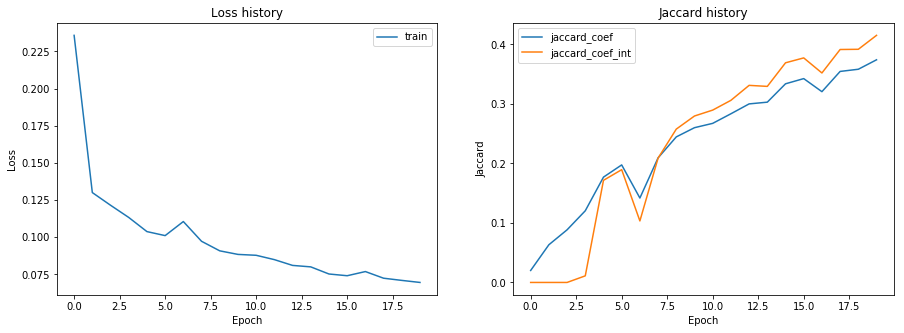

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history.history['loss'], label='train')
#ax[0].plot(history.history['val_loss'], label='val')
#plt.yscale('log')
ax[0].set_title('Loss history')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')

ax[1].plot(history.history['jaccard_coef'], label='jaccard_coef')
ax[1].plot(history.history['jaccard_coef_int'], label='jaccard_coef_int')
#ax[1].plot(history.history['val_acc'], label='val')
#plt.yscale('log')
ax[1].set_title('Jaccard history')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Jaccard')
ax[1].legend(loc='best')
plt.show()

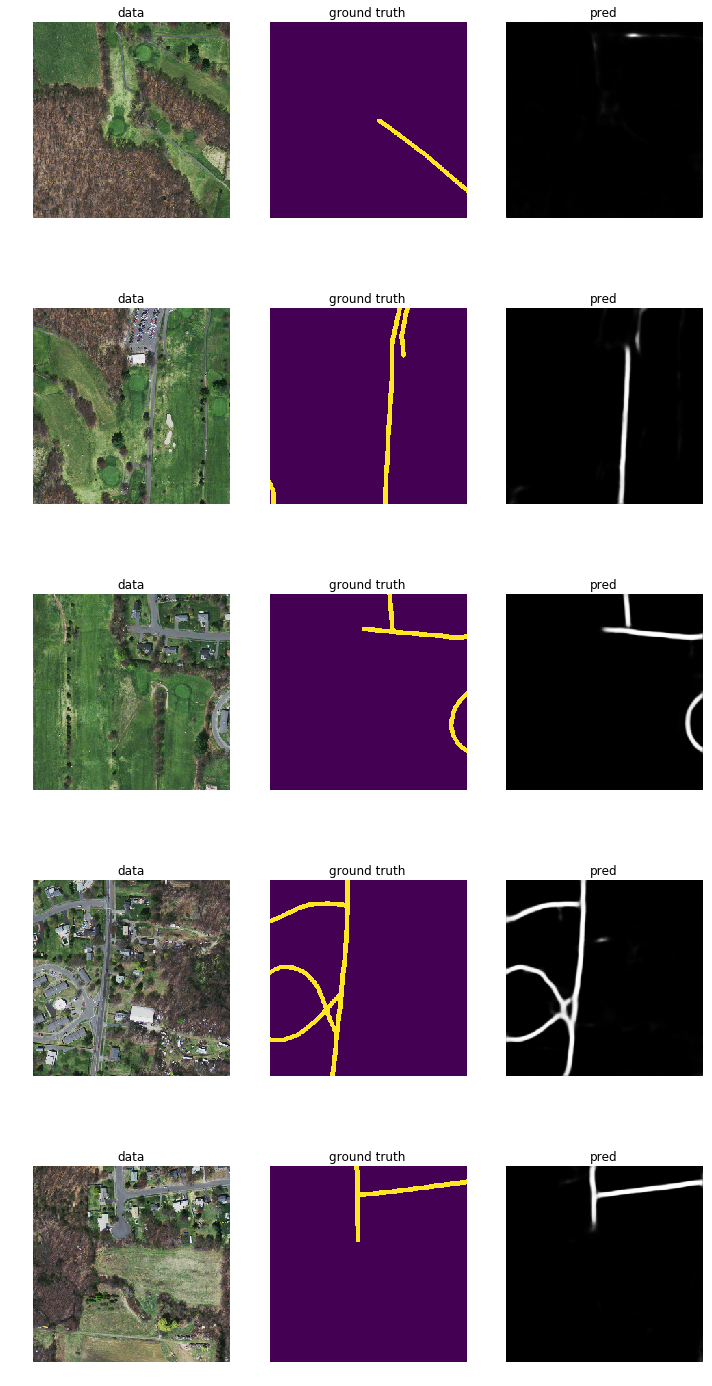

In [15]:
temp = model.predict(validationX[0:5])
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(10, 20))
ax = axes.ravel()
ax[0].imshow(validationX[0,:,:])
ax[0].set_title('data')
ax[0].axis('off')
ax[1].imshow(validationY[0,:,:,0])
ax[1].set_title('ground truth')
ax[1].axis('off')
ax[2].imshow(temp[0,:,:,0], cmap='binary_r')
ax[2].set_title('pred')
ax[2].axis('off')
ax[3].imshow(validationX[1,:,:])
ax[3].set_title('data')
ax[3].axis('off')
ax[4].imshow(validationY[1,:,:,0])
ax[4].set_title('ground truth')
ax[4].axis('off')
ax[5].imshow(temp[1,:,:,0], cmap='binary_r')
ax[5].set_title('pred')
ax[5].axis('off')
ax[6].imshow(validationX[2,:,:])
ax[6].set_title('data')
ax[6].axis('off')
ax[7].imshow(validationY[2,:,:,0])
ax[7].set_title('ground truth')
ax[7].axis('off')
ax[8].imshow(temp[2,:,:,0], cmap='binary_r')
ax[8].set_title('pred')
ax[8].axis('off')
ax[9].imshow(validationX[3,:,:])
ax[9].set_title('data')
ax[9].axis('off')
ax[10].imshow(validationY[3,:,:,0])
ax[10].set_title('ground truth')
ax[10].axis('off')
ax[11].imshow(temp[3,:,:,0], cmap='binary_r')
ax[11].set_title('pred')
ax[11].axis('off')
ax[12].imshow(validationX[4,:,:])
ax[12].set_title('data')
ax[12].axis('off')
ax[13].imshow(validationY[4,:,:,0])
ax[13].set_title('ground truth')
ax[13].axis('off')
ax[14].imshow(temp[4,:,:,0], cmap='binary_r')
ax[14].set_title('pred')
ax[14].axis('off')
plt.tight_layout()
plt.show()

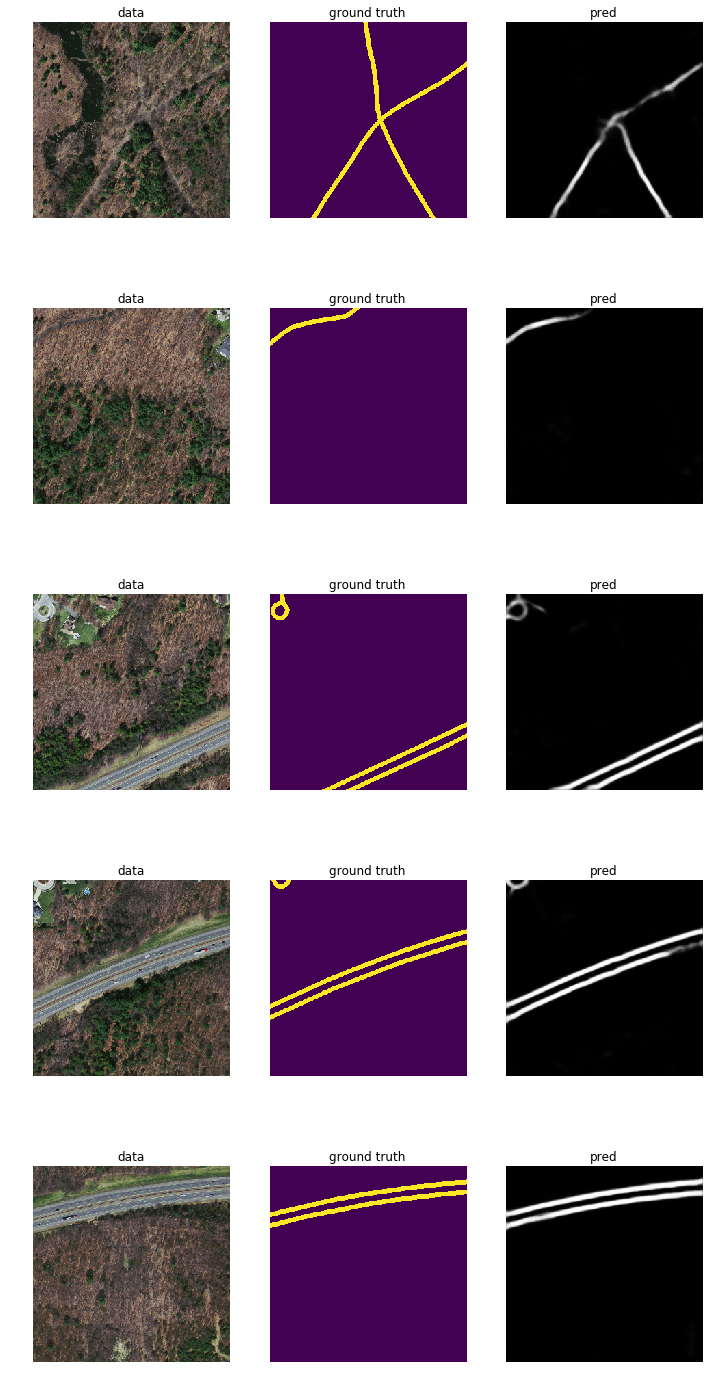

In [20]:
temp = model.predict(testX[0:5])

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(10, 20))
ax = axes.ravel()
ax[0].imshow(testX[0,:,:])
ax[0].set_title('data')
ax[0].axis('off')
ax[1].imshow(testY[0,:,:,0])
ax[1].set_title('ground truth')
ax[1].axis('off')
ax[2].imshow(temp[0,:,:,0], cmap='binary_r')
ax[2].set_title('pred')
ax[2].axis('off')
ax[3].imshow(testX[1,:,:])
ax[3].set_title('data')
ax[3].axis('off')
ax[4].imshow(testY[1,:,:,0])
ax[4].set_title('ground truth')
ax[4].axis('off')
ax[5].imshow(temp[1,:,:,0], cmap='binary_r')
ax[5].set_title('pred')
ax[5].axis('off')
ax[6].imshow(testX[2,:,:])
ax[6].set_title('data')
ax[6].axis('off')
ax[7].imshow(testY[2,:,:,0])
ax[7].set_title('ground truth')
ax[7].axis('off')
ax[8].imshow(temp[2,:,:,0], cmap='binary_r')
ax[8].set_title('pred')
ax[8].axis('off')
ax[9].imshow(testX[3,:,:])
ax[9].set_title('data')
ax[9].axis('off')
ax[10].imshow(testY[3,:,:,0])
ax[10].set_title('ground truth')
ax[10].axis('off')
ax[11].imshow(temp[3,:,:,0], cmap='binary_r')
ax[11].set_title('pred')
ax[11].axis('off')
ax[12].imshow(testX[4,:,:])
ax[12].set_title('data')
ax[12].axis('off')
ax[13].imshow(testY[4,:,:,0])
ax[13].set_title('ground truth')
ax[13].axis('off')
ax[14].imshow(temp[4,:,:,0], cmap='binary_r')
ax[14].set_title('pred')
ax[14].axis('off')
plt.tight_layout()
plt.show()